In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

In [4]:
# Nombre de tu archivo CSV (¡Ajustar!)
nombre_archivo = 'C:/Users/UX530/Desktop/TFM-GIT/Origin_Files/extended_cto_2025-09-30_09_35.csv'

try:
    df_raw = pd.read_csv(nombre_archivo, delimiter = ';')
except FileNotFoundError:
    print(f"Error: No se encontró el archivo '{nombre_archivo}'.")
    # DETENER LA EJECUCIÓN SI NO SE ENCUENTRA EL ARCHIVO REAL
    raise

## Paso 1: Limpieza, Conversión y Agregación Semanal 

In [5]:
# 1. Conversión de Fecha
df_raw['Fecha de solicitud'] = pd.to_datetime(df_raw['Fecha de solicitud'], errors='coerce')

# 2. Limpieza (Eliminar filas sin fecha o provincia)
df_limpio = df_raw.dropna(subset=['Fecha de solicitud', 'Provincia']).copy()

# 3. Agregación Semanal
df_modelo = (
    df_limpio
    .groupby([pd.Grouper(key='Fecha de solicitud', freq='W'), 'Provincia'])
    .size()
    .reset_index(name='Numero_Ampliaciones')
)

# 4. Creación de Variables de Tiempo (Año y Semana)
df_modelo['Año'] = df_modelo['Fecha de solicitud'].dt.isocalendar().year.astype(int)
df_modelo['Semana_del_Año'] = df_modelo['Fecha de solicitud'].dt.isocalendar().week.astype(int)
semana_str = df_modelo['Semana_del_Año'].astype(str).str.zfill(2) 
df_modelo['Semana_Año'] = df_modelo['Año'].astype(str) + '-W' + semana_str

print("--- 1. Resultado de Agregación (df_modelo) ---")
print(df_modelo.head())

--- 1. Resultado de Agregación (df_modelo) ---
  Fecha de solicitud    Provincia  Numero_Ampliaciones   Año  Semana_del_Año  \
0         2019-01-20     ALBACETE                    1  2019               3   
1         2019-01-20    CASTELLON                   10  2019               3   
2         2019-01-20  CIUDAD REAL                   24  2019               3   
3         2019-01-20       CUENCA                    1  2019               3   
4         2019-01-20  GUADALAJARA                    1  2019               3   

  Semana_Año  
0   2019-W03  
1   2019-W03  
2   2019-W03  
3   2019-W03  
4   2019-W03  


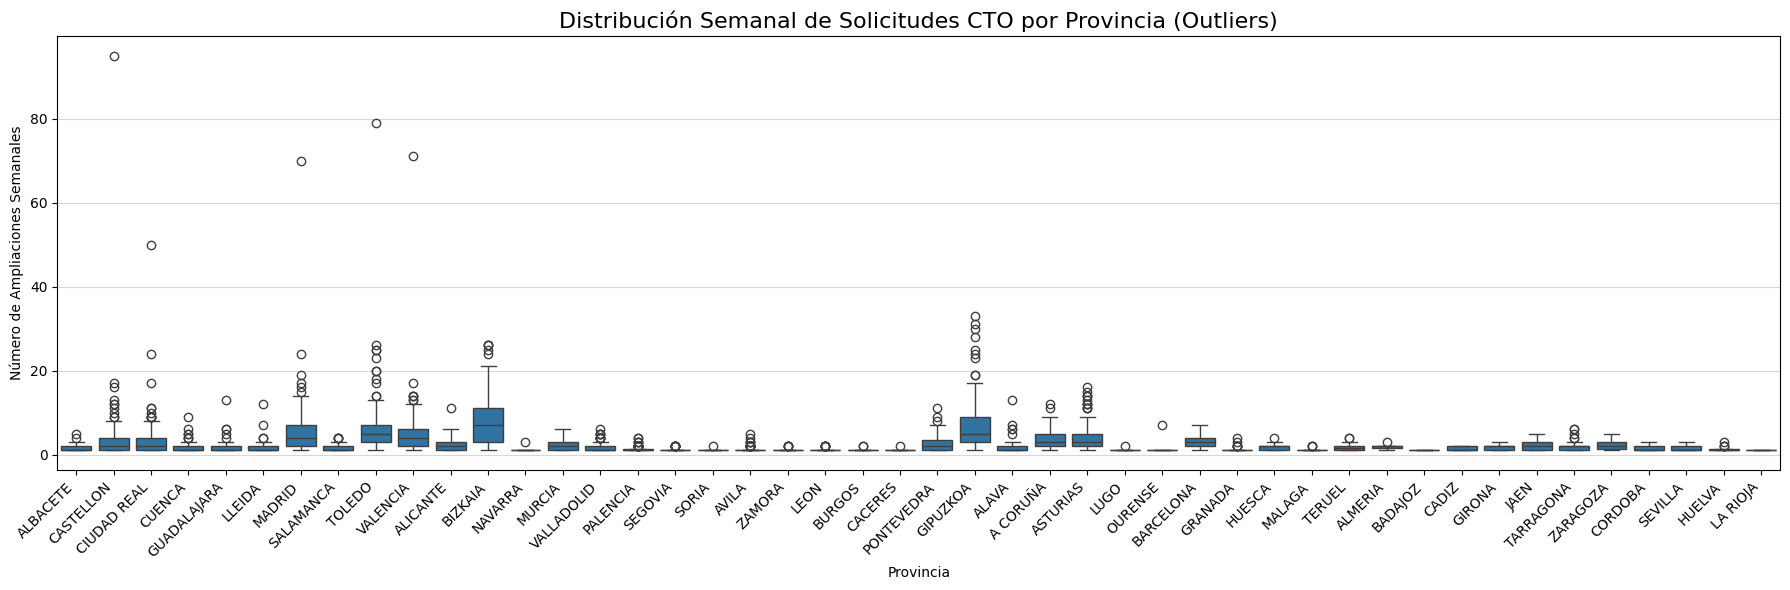

In [6]:
plt.figure(figsize=(18, 6))
sns.boxplot(x='Provincia', y='Numero_Ampliaciones', data=df_modelo)
plt.title('Distribución Semanal de Solicitudes CTO por Provincia (Outliers)', fontsize=16)
plt.xlabel('Provincia')
plt.ylabel('Número de Ampliaciones Semanales')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()
# Los puntos fuera de los bigotes son los outliers detectados.

## Paso 2: Ingeniería de Características Categóricas

In [7]:
# 1. Crear ID Numérico para Agrupamiento
df_modelo['Provincia_ID'] = df_modelo['Provincia'].astype('category').cat.codes
df_modelo['Provincia_ID'].head()

0     2
1    13
2    14
3    16
4    20
Name: Provincia_ID, dtype: int8

In [8]:
# 2. Codificación One-Hot de Provincias
df_provincias_encoded = pd.get_dummies(df_modelo['Provincia'], prefix='Provincia')
df_modelo = pd.concat([df_modelo, df_provincias_encoded], axis=1)

# 3. Eliminar la columna de texto original
df_modelo = df_modelo.drop('Provincia', axis=1)

print("\n--- 2. Resultado de Codificación One-Hot ---")
print(df_modelo.head())


--- 2. Resultado de Codificación One-Hot ---
  Fecha de solicitud  Numero_Ampliaciones   Año  Semana_del_Año Semana_Año  \
0         2019-01-20                    1  2019               3   2019-W03   
1         2019-01-20                   10  2019               3   2019-W03   
2         2019-01-20                   24  2019               3   2019-W03   
3         2019-01-20                    1  2019               3   2019-W03   
4         2019-01-20                    1  2019               3   2019-W03   

   Provincia_ID  Provincia_A CORUÑA  Provincia_ALAVA  Provincia_ALBACETE  \
0             2               False            False                True   
1            13               False            False               False   
2            14               False            False               False   
3            16               False            False               False   
4            20               False            False               False   

   Provincia_ALICANTE  ...  

## Paso 3: Ingeniería de Características Rezagadas (Lags)

In [9]:
TARGET = 'Numero_Ampliaciones'
lags_a_crear = [1, 4, 52] 

# --- CORRECCIÓN DE ERROR: DType/Unidimensionalidad ---
# Forzar la columna a ser un array simple de enteros para evitar el error 'not 1-dimensional'
df_modelo['Provincia_ID'] = df_modelo['Provincia_ID'].values.astype(int)
# ---------------------------------------------------

for lag in lags_a_crear:
    nueva_columna = f'{TARGET}_L{lag}'
    df_modelo[nueva_columna] = (
        df_modelo
        .groupby('Provincia_ID')[TARGET]
        .shift(lag)
    )

# Eliminamos las primeras filas que no tienen historia completa (L52 es NaN)
df_modelo_final = df_modelo.dropna(subset=[f'{TARGET}_L{lags_a_crear[-1]}']).copy()

print("\n--- 3. Resultado Final con Lags (df_modelo_final) ---")
print(df_modelo_final.head())


--- 3. Resultado Final con Lags (df_modelo_final) ---
    Fecha de solicitud  Numero_Ampliaciones   Año  Semana_del_Año Semana_Año  \
410         2020-03-08                    2  2020              10   2020-W10   
416         2020-03-15                    2  2020              11   2020-W11   
417         2020-03-22                    3  2020              12   2020-W12   
420         2020-03-22                    3  2020              12   2020-W12   
422         2020-03-29                    2  2020              13   2020-W13   

     Provincia_ID  Provincia_A CORUÑA  Provincia_ALAVA  Provincia_ALBACETE  \
410            41               False            False               False   
416            41               False            False               False   
417            14               False            False               False   
420            41               False            False               False   
422            28               False            False               False

## Paso 4: División de Datos (Train/Forecast)

In [11]:
# 1. Conjunto de Entrenamiento (Historia hasta W39 2025)
fecha_corte = pd.to_datetime('2025-09-28')
df_train = df_modelo_final[df_modelo_final['Fecha de solicitud'] <= fecha_corte].copy()

# 2. Definición de la lista de FEATURES
excluir_cols = ['Fecha de solicitud', 'Semana_Año', TARGET]
features = [col for col in df_train.columns if col not in excluir_cols]

# 3. Preparar X_train y y_train
X_train = df_train[features].copy()
y_train = df_train[TARGET]
X_train['Provincia_ID'] = X_train['Provincia_ID'].astype('category') # Para LightGBM

# --- 4. Creación del DataFrame de Predicción BASE (df_future) ---
fechas_futuras = pd.date_range(start='2025-10-05', periods=13, freq='W-SUN') 
provincias_ids_unicas = X_train['Provincia_ID'].unique()
columnas_provincia_dummies = [col for col in X_train.columns if col.startswith('Provincia_') or col == 'Provincia_ID']
df_provincia_dummies = X_train[columnas_provincia_dummies].drop_duplicates()

df_future = pd.DataFrame({
    'Fecha de solicitud': [f for f in fechas_futuras for p in provincias_ids_unicas],
    'Provincia_ID': [p for f in fechas_futuras for p in provincias_ids_unicas]
})

df_future['Año'] = df_future['Fecha de solicitud'].dt.isocalendar().year.astype(int)
df_future['Semana_del_Año'] = df_future['Fecha de solicitud'].dt.isocalendar().week.astype(int)
df_future = pd.merge(df_future, df_provincia_dummies, on='Provincia_ID', how='left')

# Inicializar Lags a cero
for lag in lags_a_crear:
    df_future[f'{TARGET}_L{lag}'] = 0 
    
# df_future_con_fecha: La tabla completa para el bucle iterativo (incluye la fecha para la navegación)
df_future_con_fecha = df_future.copy() 
df_future_con_fecha['Provincia_ID'] = df_future_con_fecha['Provincia_ID'].astype('category')
df_future_con_fecha.head()

,Fecha de solicitud,Provincia_ID,Año,Semana_del_Año,Provincia_A CORUÑA,Provincia_ALAVA,Provincia_ALBACETE,Provincia_ALICANTE,Provincia_ALMERIA,Provincia_ASTURIAS,...,Provincia_TARRAGONA,Provincia_TERUEL,Provincia_TOLEDO,Provincia_VALENCIA,Provincia_VALLADOLID,Provincia_ZAMORA,Provincia_ZARAGOZA,Numero_Ampliaciones_L1,Numero_Ampliaciones_L4,Numero_Ampliaciones_L52
0,2025-10-05,41,2025,40,False,False,False,False,False,False,...,False,False,True,False,False,False,False,0,0,0
1,2025-10-05,14,2025,40,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0,0,0
2,2025-10-05,28,2025,40,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0,0,0
3,2025-10-05,16,2025,40,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0,0,0
4,2025-10-05,43,2025,40,False,False,False,False,False,False,...,False,False,False,False,True,False,False,0,0,0


## Paso 5: Entrenamiento y Evaluación del Modelo LightGBM
### Usamos LightGBM con el objetivo Poisson para conteo.

In [13]:
# 1. Inicializar y Entrenar
lgb_model = lgb.LGBMRegressor(
    objective='poisson',              
    metric='rmse',                    
    n_estimators=1000,                
    learning_rate=0.05,               
    random_state=42,
    n_jobs=-1                         
)

print("Entrenando LightGBM...")
lgb_model.fit(
    X_train, 
    y_train,
    categorical_feature=['Provincia_ID'] 
)
print("✅ Entrenamiento completado.")

# 2. Evaluación (Corrección del error 'squared')
y_pred_train = lgb_model.predict(X_train)
y_pred_train[y_pred_train < 0] = 0
mse = mean_squared_error(y_train, y_pred_train) # Ahora sin 'squared=False'
rmse = np.sqrt(mse) 

print(f"Error RMSE en el conjunto de entrenamiento: {rmse:.2f}")

Entrenando LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 1878, number of used features: 22
[LightGBM] [Info] Start training from score 1.178901
✅ Entrenamiento completado.
Error RMSE en el conjunto de entrenamiento: 0.73


## Paso 6: Pronóstico Iterativo y Resultados Finales 

In [14]:
# --- Configuración del Bucle ---
df_bucle = df_future_con_fecha.copy().reset_index(drop=True)
X_modelo_bucle = df_bucle[features].copy()
preds_iterativas = []
LAG_COL_1 = f'{TARGET}_L1'
LAG_COL_4 = f'{TARGET}_L4'

# --- Bucle de Pronóstico ---
for semana_idx in range(len(fechas_futuras)):
    
    fecha_actual = fechas_futuras[semana_idx]
    
    # 1. Obtener los índices de la semana actual
    filas_actuales_idx = df_bucle[df_bucle['Fecha de solicitud'] == fecha_actual].index
    
    # 2. Crear el input del modelo para esta semana (solo features)
    X_pred_semana = X_modelo_bucle.loc[filas_actuales_idx].copy()
    X_pred_semana['Provincia_ID'] = X_pred_semana['Provincia_ID'].astype('category')
    
    # 3. Predecir y guardar
    predicciones_semana = lgb_model.predict(X_pred_semana)
    predicciones_semana = np.round(np.maximum(0, predicciones_semana)).astype(int)
    
    df_pred_semana = df_bucle.loc[filas_actuales_idx].copy()
    df_pred_semana[TARGET] = predicciones_semana
    preds_iterativas.append(df_pred_semana)
    
    # 4. Actualizar Lags para la próxima semana (si existe)
    if semana_idx + 1 < len(fechas_futuras):
        fecha_siguiente = fechas_futuras[semana_idx + 1]
        
        # Mapeo y actualización de Lags 1 y 4 en AMBOS DataFrames (df_bucle y X_modelo_bucle)
        for index, row in df_pred_semana.iterrows():
            prov_id = row['Provincia_ID']
            pred_valor = row[TARGET]
            
            idx_siguiente = df_bucle[
                (df_bucle['Fecha de solicitud'] == fecha_siguiente) & 
                (df_bucle['Provincia_ID'] == prov_id)
            ].index
            
            if not idx_siguiente.empty:
                 # Actualizar Lag 1 (T-1)
                 df_bucle.loc[idx_siguiente, LAG_COL_1] = pred_valor
                 X_modelo_bucle.loc[idx_siguiente, LAG_COL_1] = pred_valor 
                 
                 # Actualizar Lag 4 (T-4)
                 if semana_idx >= 3: 
                     preds_lag4 = preds_iterativas[semana_idx - 3] 
                     pred_valor_lag4 = preds_lag4[preds_lag4['Provincia_ID'] == prov_id][TARGET].iloc[0]
                     
                     df_bucle.loc[idx_siguiente, LAG_COL_4] = pred_valor_lag4
                     X_modelo_bucle.loc[idx_siguiente, LAG_COL_4] = pred_valor_lag4

# --- 5. Resultados Finales (Corrección DTypePromotionError) ---
df_pronostico_final = pd.concat(preds_iterativas).reset_index(drop=True)

# Recuperar el mapeo ID -> Nombre
df_map = df_raw.dropna(subset=['Provincia']).copy()
df_map['Provincia_ID'] = df_map['Provincia'].astype('category').cat.codes
mapeo_inverso = df_map[['Provincia_ID', 'Provincia']].drop_duplicates()

df_resultados = pd.merge(df_pronostico_final, mapeo_inverso, on='Provincia_ID', how='left')

df_output = df_resultados[['Fecha de solicitud', 'Provincia', TARGET]].rename(
    columns={TARGET: 'Prediccion_Numero_Ampliaciones'}
)

print("\n--- ✅ PRONÓSTICO SEMANAL FINAL (W40 a W52 2025) ---")
print(df_output.sort_values(by=['Provincia', 'Fecha de solicitud']).head(20))


--- ✅ PRONÓSTICO SEMANAL FINAL (W40 a W52 2025) ---
    Fecha de solicitud Provincia  Prediccion_Numero_Ampliaciones
6           2025-10-05  ALBACETE                               1
25          2025-10-12  ALBACETE                               1
44          2025-10-19  ALBACETE                               1
63          2025-10-26  ALBACETE                               1
82          2025-11-02  ALBACETE                               1
101         2025-11-09  ALBACETE                               1
120         2025-11-16  ALBACETE                               1
139         2025-11-23  ALBACETE                               1
158         2025-11-30  ALBACETE                               1
177         2025-12-07  ALBACETE                               1
196         2025-12-14  ALBACETE                               1
215         2025-12-21  ALBACETE                               1
234         2025-12-28  ALBACETE                               1
12          2025-10-05  ALICANTE     

### Visualización Final del Pronóstico

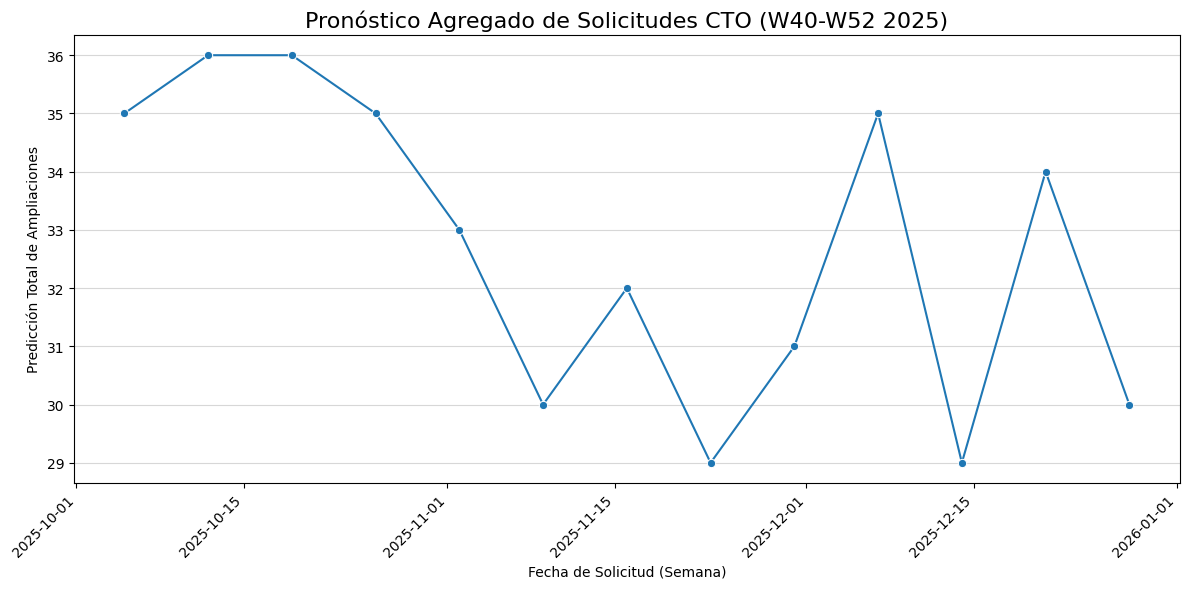

In [15]:
plt.figure(figsize=(12, 6))
df_total_semanal = df_output.groupby('Fecha de solicitud')['Prediccion_Numero_Ampliaciones'].sum().reset_index()
sns.lineplot(data=df_total_semanal, x='Fecha de solicitud', y='Prediccion_Numero_Ampliaciones', marker='o')

plt.title('Pronóstico Agregado de Solicitudes CTO (W40-W52 2025)', fontsize=16)
plt.xlabel('Fecha de Solicitud (Semana)')
plt.ylabel('Predicción Total de Ampliaciones')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()